Total de vulnerabilidades encontradas: 190
Programas con vulnerabilidades:
Git: 3
Microsoft SQL Server 2022 (64-bit): 3
Microsoft SQL Server 2022 (64-bit): 3
Mozilla Firefox (x64 es-ES): 3
Mozilla Maintenance Service: 3
: 3
: 3
Notepad++ (64-bit x64): 3
Tracker: 3
: 3
SQL Server 2022 Database Engine Services: 3
SQL Server 2022 SQL Diagnostics: 3
Microsoft ODBC Driver 17 for SQL Server: 3
SQL Server 2022 Shared Management Objects: 3
SQL Server 2022 Database Engine Shared: 3
Microsoft Update Health Tools: 3
MySQL Server 8.0: 3
Python 3.9.5 Tcl/Tk Support (64-bit): 3
SQL Server 2022 Shared Management Objects Extensions: 3
Microsoft SQL Server 2019 LocalDB : 3
Microsoft Command Line Utilities 15 for SQL Server: 3
SQL Server 2022 Database Engine Services: 3
VS JIT Debugger: 3
Python 3.12.2 Tcl/Tk Support (64-bit symbols): 3
IIS 10.0 Express: 3
Microsoft OLE DB Driver for SQL Server: 3
Azure Data Studio: 3
SQL Server 2022 Database Engine Services: 3
SQL Server 2022 Common Files: 3
SQL Server

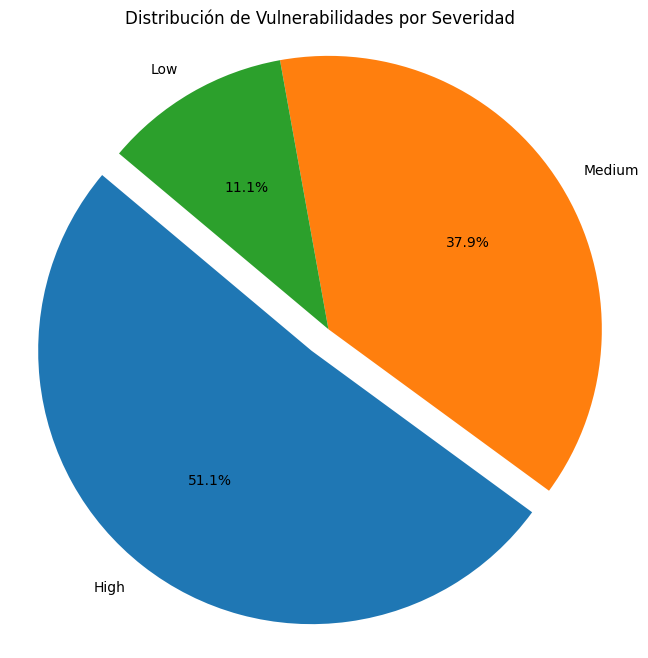

Programa con mayor cantidad de vulnerabilidades:
- Alta severidad: Git (0 vuln.)
- Media severidad: Git (2 vuln.)
- Baja severidad: Git (1 vuln.)
Resultados detallados en formato JSON:
{
    "total_vulnerabilities": 190,
    "vulnerabilities_by_severity": {
        "High": 97,
        "Medium": 72,
        "Low": 21
    }
}


In [3]:
import os
import json
import requests
from azure.cosmos import CosmosClient, PartitionKey, exceptions
from datetime import datetime as dt
from windows_tools.installed_software import get_installed_software
import matplotlib.pyplot as plt
from requests.exceptions import RequestException

# Configuración de las variables de entorno y de Azure Cosmos DB
settings = {
    'host': os.environ.get('ACCOUNT_HOST', 'https://andresdia02.documents.azure.com:443/'),
    'master_key': os.environ.get('ACCOUNT_KEY', 'ovpWKq3QnVf76g2KKnwQb2FArJz9X6lroZ3bqhvqXIkdE3rgxObPWRVWxNU6yWEwDxER5Imd983HACDbCIbnUQ=='),
    'database_id': os.environ.get('COSMOS_DATABASE', 'base1'),
    'container_id': os.environ.get('COSMOS_CONTAINER', 'container3')
}

# Variables de configuración
HOST = settings['host']
MASTER_KEY = settings['master_key']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']

# Función para crear un cliente Cosmos DB
def create_cosmos_client():
    return CosmosClient(HOST, {'masterKey': MASTER_KEY}, user_agent="CosmosDBPythonQuickstart", user_agent_overwrite=True)

# Función para crear una base de datos en Azure Cosmos DB
def create_database(client):
    try:
        return client.create_database(id=DATABASE_ID)
    except exceptions.CosmosResourceExistsError:
        return client.get_database_client(DATABASE_ID)

# Función para crear un contenedor en Azure Cosmos DB
def create_container(db_client):
    try:
        return db_client.create_container(id=CONTAINER_ID, partition_key=PartitionKey(path='/partitionKey'))
    except exceptions.CosmosResourceExistsError:
        return db_client.get_container_client(CONTAINER_ID)

# Función para buscar vulnerabilidades utilizando la API de Vulners
def search_vulnerabilities(software, max_vulnerabilities=3):
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": max_vulnerabilities
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        response.raise_for_status()  # Levanta una excepción para errores HTTP
        return response.json()
    except RequestException as e:
        print(f"Error de conexión al buscar vulnerabilidades para {software}: {e}")
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return None

# Función principal
def main():
    # Crear cliente de Azure Cosmos DB
    client = create_cosmos_client()
    # Crear base de datos en Azure Cosmos DB
    db = create_database(client)
    # Crear contenedor en Azure Cosmos DB
    container = create_container(db)

    # Obtener la lista de programas instalados en el sistema
    installed_programs = get_installed_software()
    program_vulnerabilities = []  

    # Contadores de vulnerabilidades de diferentes severidades
    high_vulnerabilities_counts = 0
    medium_vulnerabilities_counts = 0
    low_vulnerabilities_counts = 0

    # Iterar sobre los programas instalados y buscar vulnerabilidades
    for program in installed_programs:
        vulnerabilities = search_vulnerabilities(program['name'])
        if vulnerabilities and 'data' in vulnerabilities:
            program_vulnerabilities.append({'program': program['name'], 'vulnerabilities': vulnerabilities['data']['search']})
            for vulnerability in vulnerabilities['data']['search']:
                cvss_score = vulnerability['_source'].get('cvss', {}).get('score', None)
                if cvss_score:
                    if cvss_score >= 7.0:
                        high_vulnerabilities_counts += 1
                    elif 4.0 <= cvss_score < 7.0:
                        medium_vulnerabilities_counts += 1
                    else:
                        low_vulnerabilities_counts += 1

    # Calcular el total de vulnerabilidades
    total_vulnerabilities = high_vulnerabilities_counts + medium_vulnerabilities_counts + low_vulnerabilities_counts
    print(f"Total de vulnerabilidades encontradas: {total_vulnerabilities}")

    # Contar las vulnerabilidades de diferentes severidades
    vulnerabilities_counts = [high_vulnerabilities_counts, medium_vulnerabilities_counts, low_vulnerabilities_counts]
    vulnerability_labels = ['High', 'Medium', 'Low']
    
    # Ordenar los programas por cantidad de vulnerabilidades
    sorted_programs = sorted(program_vulnerabilities, key=lambda x: len(x['vulnerabilities']), reverse=True)
    print("Programas con vulnerabilidades:")
    for program in sorted_programs:
        print(f"{program['program']}: {len(program['vulnerabilities'])}")

    # Graficar las vulnerabilidades por severidad
    plot_vulnerabilities(vulnerability_labels, vulnerabilities_counts)
    
    # Imprimir el programa con la mayor cantidad de vulnerabilidades por severidad
    print("Programa con mayor cantidad de vulnerabilidades:")
    print(f"- Alta severidad: {sorted_programs[0]['program']} ({len([v for v in sorted_programs[0]['vulnerabilities'] if v['_source'].get('cvss', {}).get('score', 0) >= 7.0])} vuln.)")
    print(f"- Media severidad: {sorted_programs[0]['program']} ({len([v for v in sorted_programs[0]['vulnerabilities'] if 7.0 > v['_source'].get('cvss', {}).get('score', 0) >= 4.0])} vuln.)")
    print(f"- Baja severidad: {sorted_programs[0]['program']} ({len([v for v in sorted_programs[0]['vulnerabilities'] if v['_source'].get('cvss', {}).get('score', 0) < 4.0])} vuln.)")

    # Generar resultados en formato JSON
    results_json = {
        "total_vulnerabilities": total_vulnerabilities,
        "vulnerabilities_by_severity": {
            "High": high_vulnerabilities_counts,
            "Medium": medium_vulnerabilities_counts,
            "Low": low_vulnerabilities_counts
        }
    }
    print("Resultados detallados en formato JSON:")
    print(json.dumps(results_json, indent=4))

# Función para graficar las vulnerabilidades como un gráfico de pastel
def plot_vulnerabilities(vulnerability_labels, vulnerabilities_counts):
    # Configuración del gráfico de pastel
    plt.figure(figsize=(8, 8))
    explode = (0.1, 0, 0)  # Destacar la primera porción (vulnerabilidades altas)
    plt.pie(vulnerabilities_counts, labels=vulnerability_labels, autopct='%1.1f%%', startangle=140, explode=explode)
    plt.title('Distribución de Vulnerabilidades por Severidad')

    plt.axis('equal')  # Asegurar que el gráfico de pastel sea un círculo
    plt.show()

if __name__ == "__main__":
    main()


Total de vulnerabilidades encontradas: 189
Programas con vulnerabilidades:
Git: 3
Microsoft SQL Server 2022 (64-bit): 3
Microsoft SQL Server 2022 (64-bit): 3
Mozilla Firefox (x64 es-ES): 3
Mozilla Maintenance Service: 3
: 3
: 3
Notepad++ (64-bit x64): 3
Tracker: 3
: 3
SQL Server 2022 Database Engine Services: 3
SQL Server 2022 SQL Diagnostics: 3
Microsoft ODBC Driver 17 for SQL Server: 3
SQL Server 2022 Shared Management Objects: 3
SQL Server 2022 Database Engine Shared: 3
Microsoft Update Health Tools: 3
MySQL Server 8.0: 3
Python 3.9.5 Tcl/Tk Support (64-bit): 3
SQL Server 2022 Shared Management Objects Extensions: 3
Microsoft SQL Server 2019 LocalDB : 3
Microsoft Command Line Utilities 15 for SQL Server: 3
SQL Server 2022 Database Engine Services: 3
VS JIT Debugger: 3
Python 3.12.2 Tcl/Tk Support (64-bit symbols): 3
IIS 10.0 Express: 3
Microsoft OLE DB Driver for SQL Server: 3
Azure Data Studio: 3
SQL Server 2022 Database Engine Services: 3
SQL Server 2022 Common Files: 3
SQL Server

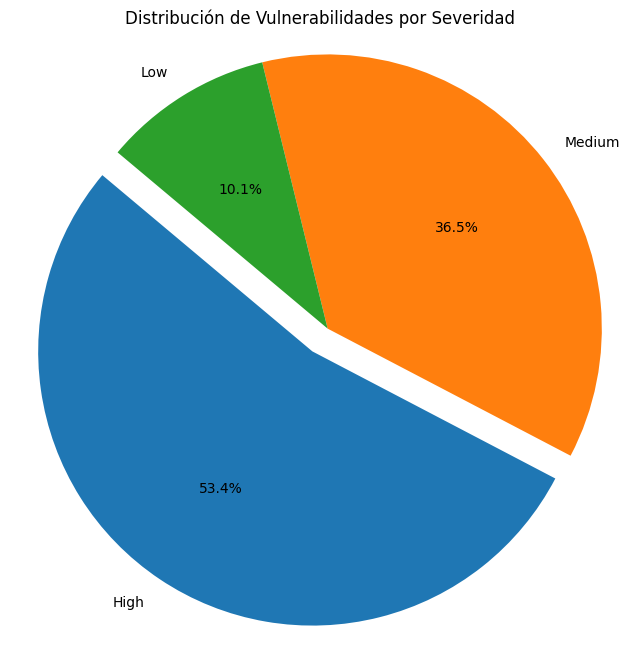

Programa con mayor cantidad de vulnerabilidades:
- Alta severidad: Git (0 vuln.)
- Media severidad: Git (2 vuln.)
- Baja severidad: Git (1 vuln.)
Resultados detallados en formato JSON:
{
    "total_vulnerabilities": 189,
    "vulnerabilities_by_severity": {
        "High": 101,
        "Medium": 69,
        "Low": 19
    },
    "programs_with_vulnerabilities": {
        "High": [
            "Microsoft SQL Server 2022 (64-bit)",
            "Microsoft SQL Server 2022 (64-bit)",
            "",
            "",
            "Notepad++ (64-bit x64)",
            "Notepad++ (64-bit x64)",
            "Tracker",
            "Tracker",
            "",
            "SQL Server 2022 Database Engine Services",
            "SQL Server 2022 SQL Diagnostics",
            "SQL Server 2022 Shared Management Objects",
            "SQL Server 2022 Shared Management Objects",
            "SQL Server 2022 Shared Management Objects",
            "SQL Server 2022 Database Engine Shared",
            "SQL Se

In [1]:
import os
import json
import requests
from azure.cosmos import CosmosClient, PartitionKey, exceptions
from windows_tools.installed_software import get_installed_software
import matplotlib.pyplot as plt
from requests.exceptions import RequestException

# Configuración de las variables de entorno y de Azure Cosmos DB
settings = {
    'host': os.environ.get('ACCOUNT_HOST', 'https://andresdia02.documents.azure.com:443/'),
    'master_key': os.environ.get('ACCOUNT_KEY', 'ovpWKq3QnVf76g2KKnwQb2FArJz9X6lroZ3bqhvqXIkdE3rgxObPWRVWxNU6yWEwDxER5Imd983HACDbCIbnUQ=='),
    'database_id': os.environ.get('COSMOS_DATABASE', 'base1'),
    'container_id': os.environ.get('COSMOS_CONTAINER', 'container3')
}

# Variables de configuración
HOST = settings['host']
MASTER_KEY = settings['master_key']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']

# Función para crear un cliente Cosmos DB
def create_cosmos_client():
    return CosmosClient(HOST, {'masterKey': MASTER_KEY}, user_agent="CosmosDBPythonQuickstart", user_agent_overwrite=True)

# Función para crear una base de datos en Azure Cosmos DB
def create_database(client):
    try:
        return client.create_database(id=DATABASE_ID)
    except exceptions.CosmosResourceExistsError:
        return client.get_database_client(DATABASE_ID)

# Función para crear un contenedor en Azure Cosmos DB
def create_container(db_client):
    try:
        return db_client.create_container(id=CONTAINER_ID, partition_key=PartitionKey(path='/partitionKey'))
    except exceptions.CosmosResourceExistsError:
        return db_client.get_container_client(CONTAINER_ID)

# Función para buscar vulnerabilidades utilizando la API de Vulners
def search_vulnerabilities(software, max_vulnerabilities=3):
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": max_vulnerabilities
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        response.raise_for_status()  # Levanta una excepción para errores HTTP
        return response.json()
    except RequestException as e:
        print(f"Error de conexión al buscar vulnerabilidades para {software}: {e}")
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return None

# Función principal
def main():
    # Crear cliente de Azure Cosmos DB
    client = create_cosmos_client()
    # Crear base de datos en Azure Cosmos DB
    db = create_database(client)
    # Crear contenedor en Azure Cosmos DB
    container = create_container(db)

    # Obtener la lista de programas instalados en el sistema
    installed_programs = get_installed_software()
    program_vulnerabilities = []  

    # Contadores de vulnerabilidades de diferentes severidades
    high_vulnerabilities_counts = 0
    medium_vulnerabilities_counts = 0
    low_vulnerabilities_counts = 0

    # Listas para almacenar los nombres de los programas con diferentes severidades de vulnerabilidad
    high_vulnerability_programs = []
    medium_vulnerability_programs = []
    low_vulnerability_programs = []

    # Iterar sobre los programas instalados y buscar vulnerabilidades
    for program in installed_programs:
        vulnerabilities = search_vulnerabilities(program['name'])
        if vulnerabilities and 'data' in vulnerabilities:
            program_vulnerabilities.append({'program': program['name'], 'vulnerabilities': vulnerabilities['data']['search']})
            for vulnerability in vulnerabilities['data']['search']:
                cvss_score = vulnerability['_source'].get('cvss', {}).get('score', None)
                if cvss_score:
                    if cvss_score >= 7.0:
                        high_vulnerabilities_counts += 1
                        high_vulnerability_programs.append(program['name'])
                    elif 4.0 <= cvss_score < 7.0:
                        medium_vulnerabilities_counts += 1
                        medium_vulnerability_programs.append(program['name'])
                    else:
                        low_vulnerabilities_counts += 1
                        low_vulnerability_programs.append(program['name'])

    # Calcular el total de vulnerabilidades
    total_vulnerabilities = high_vulnerabilities_counts + medium_vulnerabilities_counts + low_vulnerabilities_counts
    print(f"Total de vulnerabilidades encontradas: {total_vulnerabilities}")

    # Contar las vulnerabilidades de diferentes severidades
    vulnerabilities_counts = [high_vulnerabilities_counts, medium_vulnerabilities_counts, low_vulnerabilities_counts]
    vulnerability_labels = ['High', 'Medium', 'Low']
    
    # Ordenar los programas por cantidad de vulnerabilidades
    sorted_programs = sorted(program_vulnerabilities, key=lambda x: len(x['vulnerabilities']), reverse=True)
    print("Programas con vulnerabilidades:")
    for program in sorted_programs:
        print(f"{program['program']}: {len(program['vulnerabilities'])}")

    # Graficar las vulnerabilidades por severidad
    plot_vulnerabilities(vulnerability_labels, vulnerabilities_counts)
    
    # Imprimir el programa con la mayor cantidad de vulnerabilidades por severidad
    print("Programa con mayor cantidad de vulnerabilidades:")
    print(f"- Alta severidad: {sorted_programs[0]['program']} ({len([v for v in sorted_programs[0]['vulnerabilities'] if v['_source'].get('cvss', {}).get('score', 0) >= 7.0])} vuln.)")
    print(f"- Media severidad: {sorted_programs[0]['program']} ({len([v for v in sorted_programs[0]['vulnerabilities'] if 7.0 > v['_source'].get('cvss', {}).get('score', 0) >= 4.0])} vuln.)")
    print(f"- Baja severidad: {sorted_programs[0]['program']} ({len([v for v in sorted_programs[0]['vulnerabilities'] if v['_source'].get('cvss', {}).get('score', 0) < 4.0])} vuln.)")

    # Generar resultados en formato JSON
    results_json = {
        "total_vulnerabilities": total_vulnerabilities,
        "vulnerabilities_by_severity": {
            "High": high_vulnerabilities_counts,
            "Medium": medium_vulnerabilities_counts,
            "Low": low_vulnerabilities_counts
        },
        "programs_with_vulnerabilities": {
            "High": high_vulnerability_programs,
            "Medium": medium_vulnerability_programs,
            "Low": low_vulnerability_programs
        }
    }
    print("Resultados detallados en formato JSON:")
    print(json.dumps(results_json, indent=4))

# Función para graficar las vulnerabilidades como un gráfico de pastel
def plot_vulnerabilities(vulnerability_labels, vulnerabilities_counts):
    # Configuración del gráfico de pastel
    plt.figure(figsize=(8, 8))
    explode = (0.1, 0, 0)  # Destacar la primera porción (vulnerabilidades altas)
    plt.pie(vulnerabilities_counts, labels=vulnerability_labels, autopct='%1.1f%%', startangle=140, explode=explode)
    plt.title('Distribución de Vulnerabilidades por Severidad')

    plt.axis('equal')  # Asegurar que el gráfico de pastel sea un círculo
    plt.show()

if __name__ == "__main__":
    main()


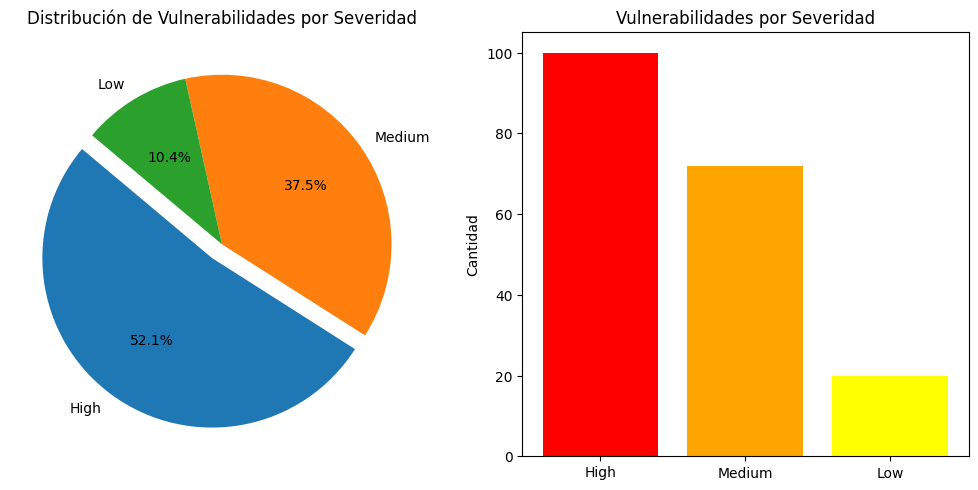

In [1]:
import os
import json
import requests
import matplotlib.pyplot as plt
from azure.cosmos import CosmosClient, PartitionKey, exceptions
from windows_tools.installed_software import get_installed_software
from requests.exceptions import RequestException

# Configuración de las variables de entorno y de Azure Cosmos DB
settings = {
    'host': os.environ.get('ACCOUNT_HOST', 'https://andresdia02.documents.azure.com:443/'),
    'master_key': os.environ.get('ACCOUNT_KEY', 'ovpWKq3QnVf76g2KKnwQb2FArJz9X6lroZ3bqhvqXIkdE3rgxObPWRVWxNU6yWEwDxER5Imd983HACDbCIbnUQ=='),
    'database_id': os.environ.get('COSMOS_DATABASE', 'base1'),
    'container_id': os.environ.get('COSMOS_CONTAINER', 'container3')
}

# Variables de configuración
HOST = settings['host']
MASTER_KEY = settings['master_key']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']

# Función para crear un cliente Cosmos DB
def create_cosmos_client():
    return CosmosClient(HOST, {'masterKey': MASTER_KEY}, user_agent="CosmosDBPythonQuickstart", user_agent_overwrite=True)

# Función para crear una base de datos en Azure Cosmos DB
def create_database(client):
    try:
        return client.create_database(id=DATABASE_ID)
    except exceptions.CosmosResourceExistsError:
        return client.get_database_client(DATABASE_ID)

# Función para crear un contenedor en Azure Cosmos DB
def create_container(db_client):
    try:
        return db_client.create_container(id=CONTAINER_ID, partition_key=PartitionKey(path='/partitionKey'))
    except exceptions.CosmosResourceExistsError:
        return db_client.get_container_client(CONTAINER_ID)

# Función para buscar vulnerabilidades utilizando la API de Vulners
def search_vulnerabilities(software, max_vulnerabilities=3):
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": max_vulnerabilities
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        response.raise_for_status()  # Levanta una excepción para errores HTTP
        return response.json()
    except RequestException as e:
        print(f"Error de conexión al buscar vulnerabilidades para {software}: {e}")
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return None

# Función principal
def main():
    # Crear cliente de Azure Cosmos DB
    client = create_cosmos_client()
    # Crear base de datos en Azure Cosmos DB
    db = create_database(client)
    # Crear contenedor en Azure Cosmos DB
    container = create_container(db)

    # Obtener la lista de programas instalados en el sistema
    installed_programs = get_installed_software()
    program_vulnerabilities = []

    # Contadores de vulnerabilidades de diferentes severidades
    high_vulnerabilities_counts = 0
    medium_vulnerabilities_counts = 0
    low_vulnerabilities_counts = 0

    # Iterar sobre los programas instalados y buscar vulnerabilidades
    for program in installed_programs:
        vulnerabilities = search_vulnerabilities(program['name'])
        if vulnerabilities and 'data' in vulnerabilities:
            program_vulnerabilities.append({'program': program['name'], 'vulnerabilities': vulnerabilities['data']['search']})
            for vulnerability in vulnerabilities['data']['search']:
                cvss_score = vulnerability['_source'].get('cvss', {}).get('score', None)
                if cvss_score:
                    if cvss_score >= 7.0:
                        high_vulnerabilities_counts += 1
                    elif 4.0 <= cvss_score < 7.0:
                        medium_vulnerabilities_counts += 1
                    else:
                        low_vulnerabilities_counts += 1

    # Guardar los datos en la base de datos
    items_to_insert = [{
        "id": str(index),
        "program": program['program'],
        "high_vulnerabilities": high_vulnerabilities_counts,
        "medium_vulnerabilities": medium_vulnerabilities_counts,
        "low_vulnerabilities": low_vulnerabilities_counts
    } for index, program in enumerate(program_vulnerabilities)]

    for item in items_to_insert:
        container.create_item(body=item)

    # Graficar las vulnerabilidades por severidad
    plot_vulnerabilities(high_vulnerabilities_counts, medium_vulnerabilities_counts, low_vulnerabilities_counts)

# Función para graficar las vulnerabilidades como un gráfico de pastel y uno de barras
def plot_vulnerabilities(high_count, medium_count, low_count):
    # Gráfico de pastel
    labels = 'High', 'Medium', 'Low'
    sizes = [high_count, medium_count, low_count]
    explode = (0.1, 0, 0)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribución de Vulnerabilidades por Severidad')

    # Gráfico de barras
    plt.subplot(1, 2, 2)
    heights = [high_count, medium_count, low_count]
    bars = ('High', 'Medium', 'Low')
    y_pos = range(len(bars))
    plt.bar(y_pos, heights, color=['red', 'orange', 'yellow'])
    plt.xticks(y_pos, bars)
    plt.title('Vulnerabilidades por Severidad')
    plt.ylabel('Cantidad')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
